In [4]:
import numpy as np
import pandas as pd
 
data_df = pd.read_csv('AMZN.csv')[::-1]
data_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
2264,12/29/2018,1510.800049,1520.760010,1487.000000,1501.969971,6954500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501.969971,NaN
2263,12/31/2018,1510.800049,1520.760010,1487.000000,1501.969971,6954500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501.969971,NaN
2262,12/28/2018,1473.349976,1513.469971,1449.000000,1478.020020,8829000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1478.020020,NaN
2261,12/27/2018,1454.199951,1469.000000,1390.310059,1461.640015,9722000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.640015,NaN
2260,12/26/2018,1368.890015,1473.160034,1363.010010,1470.900024,10411800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1470.900024,NaN


In [5]:
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Data Preprocessing

In [6]:
def shuffle_in_unison(a, b):
  assert len(a) == len(b)
  shuffled_a = np.empty(a.shape, dtype=a.dtype)
  shuffled_b = np.empty(b.shape, dtype=b.dtype)
  permutation = np.random.permutation(len(a))
  for old_index, new_index in enumerate(permutation):
    shuffled_a[new_index] = a[old_index]
    shuffled_b[new_index] = b[old_index]
  return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
  p = int(len(X) * percentage)
  X_train = X[0:p]
  Y_train = y[0:p]
  X_train, Y_train = shuffle_in_unison(X_train, Y_train)
  
  X_test = X[p:]
  Y_test = y[p:]
  
  return X_train, X_test, Y_train, Y_test

 
def remove_nan_examples(data):
  newX = []
  for i in range(len(data)):
    if np.isnan(data[i]).any() == False:
      newX.append(data[i])
  return newX

In [7]:
#converting all OHLCV data into list formats so appending will be easy
openp = data_df.loc[:, 'Open'].tolist()  
highp = data_df.loc[:, 'High'].tolist()
lowp = data_df.loc[:, 'Low'].tolist()
closep = data_df.loc[:, 'Close'].tolist()
volumep = data_df.loc[:, 'Volume'].tolist()


WINDOW = 30   #keeping a window of 30 days for EMA
EMB_SIZE = 5  
STEP = 1
FORECAST = 1 #one day forecast  
X, Y = [], []
for i in range(0, len(data_df), STEP):  #creating a counter for data with step size 1
    try:
        o = openp[i:i+WINDOW]  #declaring a window and sample through each stock price
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)  # normalizing the stock values by finding difference in array lenth and mean and dividing by stdev
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]           #creating train for close price
        y_i = closep[i+WINDOW+FORECAST]    #adding forecast for output price

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close: 
            y_i = [1, 0]              #label when closing price increases     
        else:
            y_i = [0, 1]              #label when closing price decreases

        x_i = np.column_stack((o, h, l, c, v))   

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))  #reshaping train to LSTM network requirements
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))


## LSTM MODEL

In [8]:
from keras import backend as K 
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [16]:
model = build_model(X_train, output_size=2, neurons = 32) #model output is next price normalised to 10th previous closing price

history = model.fit(X_train, Y_train,
                            epochs=100, batch_size=128, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/100
16/16 [==============================] - 1s 73ms/step - loss: 0.4872 - accuracy: 0.5209 - mean_pred: 0.2137 - val_accuracy: 0.5446 - val_loss: 0.4649 - val_mean_pred: 0.2848
Epoch 2/100
16/16 [==============================] - 0s 28ms/step - loss: 0.4763 - accuracy: 0.5269 - mean_pred: 0.2460 - val_accuracy: 0.5357 - val_loss: 0.4679 - val_mean_pred: 0.2354
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 0.4737 - accuracy: 0.5363 - mean_pred: 0.2617 - val_accuracy: 0.5223 - val_loss: 0.4668 - val_mean_pred: 0.2457
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.4688 - accuracy: 0.5483 - mean_pred: 0.2553 - val_accuracy: 0.5357 - val_loss: 0.4611 - val_mean_pred: 0.3213
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.4579 - accuracy: 0.5478 - mean_pred: 0.3558 - val_accuracy: 0.5357 - val_loss: 0.4587 - val_mean_pred: 0.4079
Epoch 6/100
16/16 [==============================] - 0s 20ms/step - lo

The model shows a training accuracy of 73% presently.

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [18]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 7ms/step - loss: 0.3507 - accuracy: 0.7009 - mean_pred: 0.4243
Test accuracy: [0.35065945982933044, 0.7008928656578064, 0.4242768883705139]


As for test accuracy, the model is currently at 70%.

### Evaluation of initial model

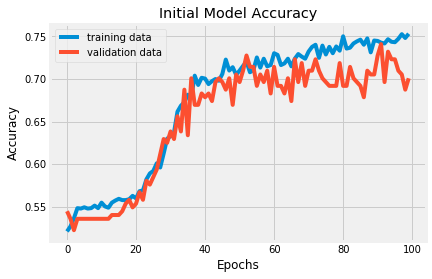

In [19]:
#Plotting training loss vs validation loss
plt.plot(history.history['accuracy'], label = 'training data')
plt.plot(history.history['val_accuracy'], label = 'validation data')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Initial Model Accuracy')
plt.show()

A pretty decent model, all things considered. 

Normalized values difference is at 0.025, so there isn't much overfitting.

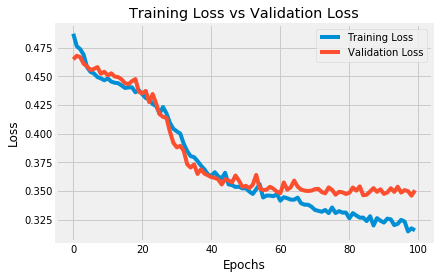

In [20]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Hyperparameter Tuning

I plan to tune the LSTM model to the best version by: 

* Changing activation function and cost function
 
 elu with rmsprop and sgd along with mse and logcosh

* Trying for more epochs

* Initializers of random uniform and zeros


### Elu with mse and rmsprop

In [21]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="elu",
                dropout=0.10, loss="mse", optimizer="rmsprop"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size, kernel_initializer='random_uniform'))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [22]:
model = build_model(X_train, output_size=2, neurons = 32)

history = model.fit(X_train, Y_train,
                            epochs=100, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/100
8/8 [==============================] - 1s 148ms/step - loss: 0.4530 - accuracy: 0.5129 - mean_pred: 0.0541 - val_accuracy: 0.5491 - val_loss: 0.3902 - val_mean_pred: 0.1314
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 0.3490 - accuracy: 0.5398 - mean_pred: 0.2065 - val_accuracy: 0.5357 - val_loss: 0.2839 - val_mean_pred: 0.3366
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 0.2659 - accuracy: 0.5468 - mean_pred: 0.4110 - val_accuracy: 0.5357 - val_loss: 0.2510 - val_mean_pred: 0.4862
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 0.2510 - accuracy: 0.5473 - mean_pred: 0.4917 - val_accuracy: 0.5357 - val_loss: 0.2489 - val_mean_pred: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 45ms/step - loss: 0.2501 - accuracy: 0.5498 - mean_pred: 0.4971 - val_accuracy: 0.5357 - val_loss: 0.2480 - val_mean_pred: 0.4999
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 0.2494 

The training accuracy has improved to around 72%, which is not a significant increase.

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


In [24]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 7ms/step - loss: 0.1914 - accuracy: 0.7411 - mean_pred: 0.4979
Test accuracy: [0.19135305285453796, 0.7410714030265808, 0.49785372614860535]


The testing accuracy is at 74%.

#### Evaluation

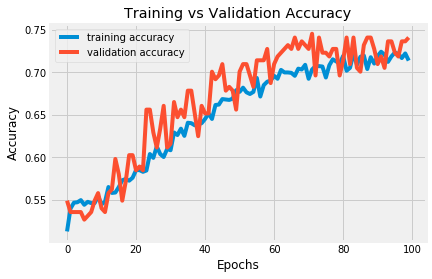

In [25]:
#Accuracy
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

The model may be slightly overfit, but that is expected after training for 100 epochs.

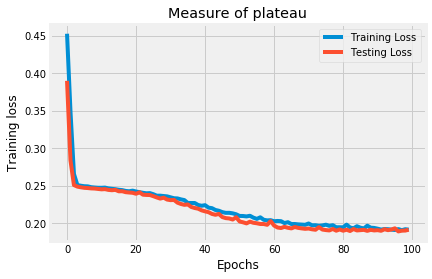

In [26]:
#Loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Measure of plateau')
plt.show()

# GRU MODEL

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. 

GRUs do not have cell states and use the hidden state to transfer information. 

A GRU network also only has two gates, a reset gate and update gate.

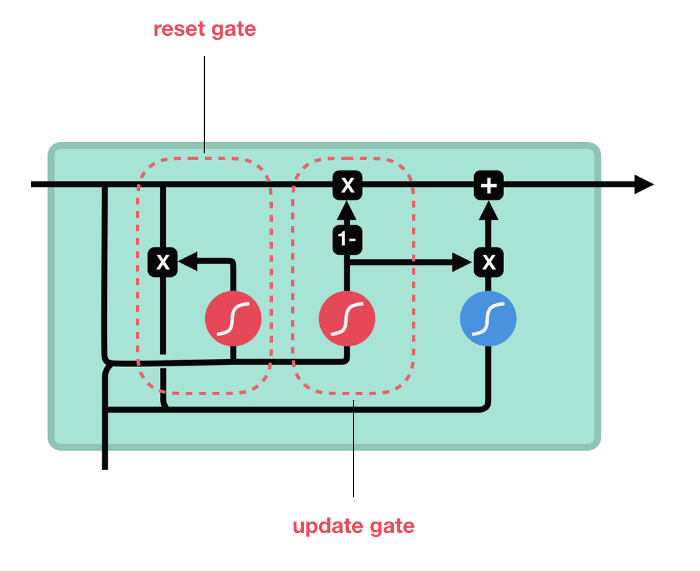

The two gates in a GRU network are:

* Update Gate
  
  The update gate acts similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.

* Reset Gate
  
  The reset gate is another gate is used to decide how much past information to forget.

In [27]:
def mean_pred(X_test, Y_test):
    return K.mean(Y_test)

def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(GRU(neurons, input_shape=(WINDOW,EMB_SIZE)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', mean_pred])
    return model

In [28]:
model = build_model(X_train, output_size=2, neurons = 32)

history = model.fit(X_train, Y_train,
                            epochs=50, batch_size=256, verbose=1,  validation_data=(X_test, Y_test),shuffle=True)

Epoch 1/50
8/8 [==============================] - 1s 120ms/step - loss: 0.4825 - accuracy: 0.5279 - mean_pred: 0.2232 - val_accuracy: 0.5759 - val_loss: 0.4743 - val_mean_pred: 0.1920
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.4723 - accuracy: 0.5443 - mean_pred: 0.2022 - val_accuracy: 0.5714 - val_loss: 0.4690 - val_mean_pred: 0.2155
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.4686 - accuracy: 0.5488 - mean_pred: 0.2335 - val_accuracy: 0.5759 - val_loss: 0.4650 - val_mean_pred: 0.2357
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.4667 - accuracy: 0.5527 - mean_pred: 0.2358 - val_accuracy: 0.6027 - val_loss: 0.4635 - val_mean_pred: 0.2322
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.4574 - accuracy: 0.5612 - mean_pred: 0.2475 - val_accuracy: 0.5982 - val_loss: 0.4555 - val_mean_pred: 0.2549
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.4546 - accu

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3744      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
Total params: 3,810
Trainable params: 3,810
Non-trainable params: 0
_________________________________________________________________


In [30]:
acc = model.evaluate(X_test, Y_test, batch_size=16)
print('Test accuracy:', acc)

14/14 [==============================] - 0s 7ms/step - loss: 0.3527 - accuracy: 0.7054 - mean_pred: 0.4059
Test accuracy: [0.35270190238952637, 0.7053571343421936, 0.4058668315410614]


### Evaluation 

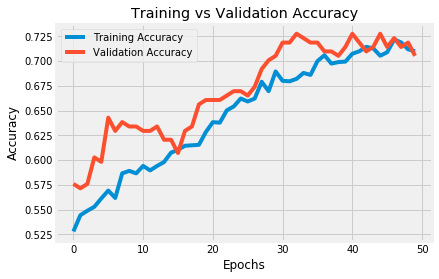

In [31]:
#Plotting training loss and validation accuracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

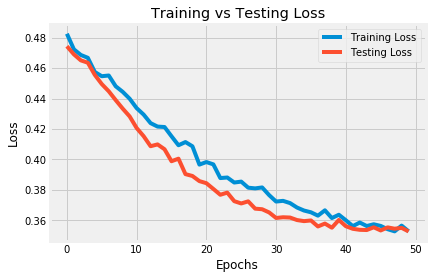

In [32]:
#Loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.show()